**Analysising windowing method fro normalising inputs with an unknown input range**


In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

Get data from file and put it in an numpy array

In [11]:
nbie_data = pd.read_csv('ke_log.csv')

nbie_data.columns = ['a']

nbie_data = nbie_data["a"].str.split("/", n = 1, expand = True)

nbie_data.columns = ['1', '2']

new_data = nbie_data.loc[nbie_data['1'] == 'KE raw ']

d = pd.DataFrame(new_data, columns=["2"])

RawEnergies = np.asarray(d['2'].tolist(), dtype=np.float32)

norm_data = nbie_data.loc[nbie_data['1'] == 'KE nor ']
e = pd.DataFrame(norm_data, columns=["2"])
NormEnergiesVS = np.asarray(e['2'].tolist(), dtype=np.float32)

norm_data = nbie_data.loc[nbie_data['1'] == 'Min ']
minL = pd.DataFrame(norm_data, columns=["2"])
VSMins = np.asarray(minL['2'].tolist(), dtype=np.float32)

norm_data = nbie_data.loc[nbie_data['1'] == 'Max ']
maxL = pd.DataFrame(norm_data, columns=["2"])
VSMaxs = np.asarray(maxL['2'].tolist(), dtype=np.float32)

norm_data = nbie_data.loc[nbie_data['1'] == 'Mean ']
meanL = pd.DataFrame(norm_data, columns=["2"])
VSMeans = np.asarray(meanL['2'].tolist(), dtype=np.float32)

norm_data = nbie_data.loc[nbie_data['1'] == 'SD ']
sdL = pd.DataFrame(norm_data, columns=["2"])
VSSds = np.asarray(sdL['2'].tolist(), dtype=np.float32)


In [35]:
# Trim the array so we can divided it into an even number of windows
windowSize = 20
remainder = RawEnergies.size % windowSize
RawEnergiesTrim = RawEnergies[0:RawEnergies.size-remainder]
numBuffers = RawEnergiesTrim.size / windowSize

# Split the raw values array into windows 
windows = np.array_split(RawEnergiesTrim, numBuffers)

# 1. Work out the Mean (the simple average of the numbers)
# 2. Then for each number: subtract the Mean and square the result
# 3. Then work out the mean of those squared differences.
# 4. Take the square root of that and we are done!

NormEnergiesNB = np.zeros(RawEnergiesTrim.size)
Velocity = np.zeros(RawEnergiesTrim.size)


absMinimums = np.zeros(int(numBuffers))
absMaximums = np.zeros(int(numBuffers))
minimums = np.zeros(int(numBuffers))
maximums = np.zeros(int(numBuffers))
means = np.zeros(int(numBuffers))
sds = np.zeros(int(numBuffers))

# median value windowing

count = 0
rangeMultiplier = 0.6
# For each window, calculate the standard deviation 
for w in windows:
    absMin = np.min(w)
    absMax = np.max(w)
    
    median = np.median(w)
    mean = np.mean(w) 
    diff = w - mean
    sqDiff = np.power(diff, 2)
    sqDiffMean = np.mean(sqDiff)
    sdnp = np.sqrt(sqDiffMean)
    
    sq_sum = np.inner(w, w);        
    sd = np.sqrt(sq_sum / w.size - mean * mean);
    
    # Define a min and max based of the mean and SD
    min= (mean - (2.0 * sd)) * (1 - rangeMultiplier)
    max= (mean + (2.0 * sd)) * (1 + rangeMultiplier)
    
    # Define a min and max based on the median value
    #min= median - (10.0 * np.std(w))
    #max= median + (10.0 * np.std(w))
    
    minimums[count] = min
    maximums[count] = max
    means[count] = mean
    sds[count] = sd
    absMinimums[count] = absMin
    absMaximums[count] = absMax
    count = count+1
        
    
# As this is a realtime method, the min and max from the previous buffer 
# are used to calculate the normalisation for the current buffer 
        
# The first window sized chuck of values are set to zero as we have nothing to normalise them against
dummy = np.arange(0, windowSize, 1)
for i in dummy:
    NormEnergiesNB[i] = 0        
        
rampCoeff = 0.99
invRampCoeff = 1 - rampCoeff
energyCount = windowSize
minMaxCount = 0
#For the second buffer 
for w in windows[1:int(numBuffers)]:
    # Normalise the values in this window based on the min and max from the previous window
    minLocal = minimums[minMaxCount]
    maxLocal = maximums[minMaxCount]    
    minMaxCount = minMaxCount + 1
    for i in w:
#          if i > maxLocal:
#              maxLocal = (i * invRampCoeff) + (maxLocal * rampCoeff)
#          if i < minLocal: 
#              minLocal = (i * invRampCoeff) + (minLocal * rampCoeff)
        norm = (i - minLocal) / (maxLocal - minLocal)
        NormEnergiesNB[energyCount] = norm
        energyCount = energyCount+1
    
    
#clamp the normalised values 
NormEnergiesNB = np.clip(NormEnergiesNB, 0, 1)

# compress the range by raising them to power 3
NormEnergiesNB = np.power(NormEnergiesNB, 3)



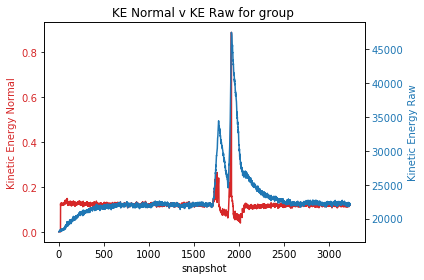

In [36]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('snapshot')
ax1.set_ylabel('Kinetic Energy Normal', color=color)
ax1.set_title('KE Normal v KE Raw for group ')
ax1.plot(NormEnergiesNB, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Kinetic Energy Raw', color=color)  # we already handled the x-label with ax1
ax2.plot(RawEnergies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
t = 'non-bonded-energy v distance for group '
plt.show()


18047.5
47498.5


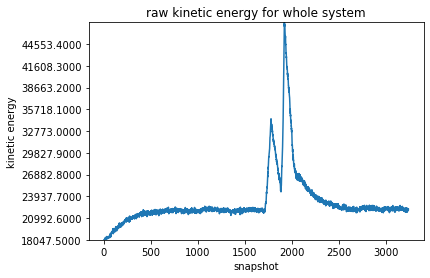

In [37]:
max = np.max(RawEnergies)
min = np.min(RawEnergies)
    
print(min)
print(max)

fig, ax = plt.subplots()

ax.plot(RawEnergies)

t = 'raw kinetic energy for whole system'
ax.set(xlabel='snapshot', ylabel='kinetic energy', title=t)

yt = (max - min) / 10.0
    
plt.ylim(min, max)  
y_ticks = np.arange(min, max, yt)
plt.yticks(y_ticks)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.savefig('raw kinetic energy')
plt.show()

0.0
0.8867572816410659


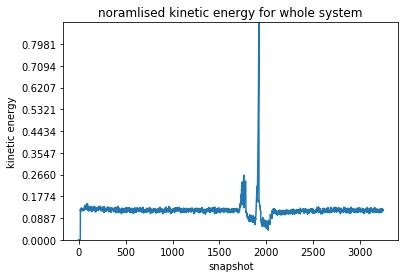

In [38]:
max = np.max(NormEnergiesNB)
min = np.min(NormEnergiesNB)
    
print(min)
print(max)

fig, ax = plt.subplots()

ax.plot(NormEnergiesNB)

t = 'noramlised kinetic energy for whole system'
ax.set(xlabel='snapshot', ylabel='kinetic energy', title=t)

yt = (max - min) / 10.0
    
plt.ylim(min, max)  
y_ticks = np.arange(min, max, yt)
plt.yticks(y_ticks)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.savefig('Normalised kinetic energy')
plt.show()

0.044024
1.0


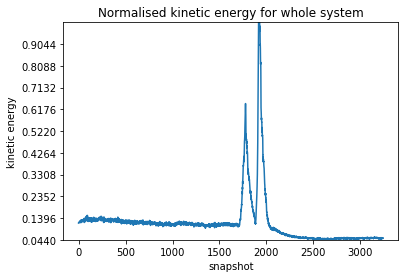

In [39]:
max = np.max(NormEnergiesVS)
min = np.min(NormEnergiesVS)
    
print(min)
print(max)

fig, ax = plt.subplots()

ax.plot(NormEnergiesVS)

t = 'Normalised kinetic energy for whole system'
ax.set(xlabel='snapshot', ylabel='kinetic energy', title=t)

yt = (max - min) / 10.0
    
plt.ylim(min, max)  
y_ticks = np.arange(min, max, yt)
plt.yticks(y_ticks)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.savefig('raw kinetic energy')
plt.show()

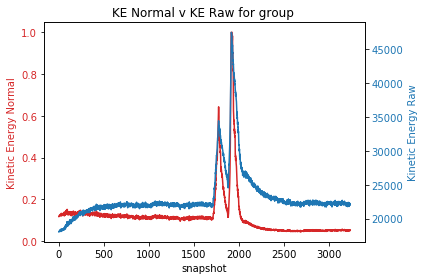

In [40]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('snapshot')
ax1.set_ylabel('Kinetic Energy Normal', color=color)
ax1.set_title('KE Normal v KE Raw for group ')
ax1.plot(NormEnergiesVS, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Kinetic Energy Raw', color=color)  # we already handled the x-label with ax1
ax2.plot(RawEnergies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
t = 'non-bonded-energy v distance for group '
plt.savefig('normal vs raw')
plt.show()

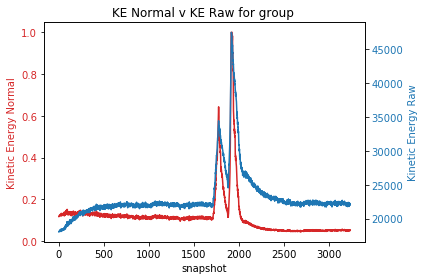

In [24]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('snapshot')
ax1.set_ylabel('Kinetic Energy Normal', color=color)
ax1.set_title('KE Normal v KE Raw for group ')
ax1.plot(NormEnergiesVS, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Kinetic Energy Raw', color=color)  # we already handled the x-label with ax1
ax2.plot(RawEnergies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
t = 'non-bonded-energy v distance for group '
plt.savefig(t)
plt.show()

In [ ]:
trim = RawEnergies[1::windowSize]
trimtrim = trim[0:trim.size-1]
print(trimtrim.size)
diff = maximums - minimums
norm = (trimtrim - minimums) / diff

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('snapshot')
ax1.set_ylabel('Diff', color=color)
ax1.set_title('Diff ')
ax1.plot(norm, color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Raw', color=color)  # we already handled the x-label with ax1
ax2.plot(RawEnergies[1::windowSize], color=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
m

In [ ]:
NormEnergies

In [ ]:
NorEnergies

In [ ]:
VSMeans

In [ ]:
means